## Data Loading

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
IMAGE_SIZE = 227
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'rice_leaf_disease_images',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 7926 files belonging to 5 classes.


In [4]:
class_names = dataset.class_names
class_names

['Bacterialblight', 'Blast', 'Brownspot', 'Healthy', 'Tungro']

In [5]:
len(dataset) #186*32=5931

248

In [6]:
# One random batch of images
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 227, 227, 3)
[4 1 1 2 1 0 4 2 3 2 0 4 3 4 1 0 3 2 0 4 0 0 1 4 4 1 2 3 4 3 3 4]


(32, 227, 227, 3)
[1 4 0 0 0 1 3 3 4 1 2 3 1 4 0 4 0 2 4 1 1 2 2 1 1 0 3 0 1 0 1 0]


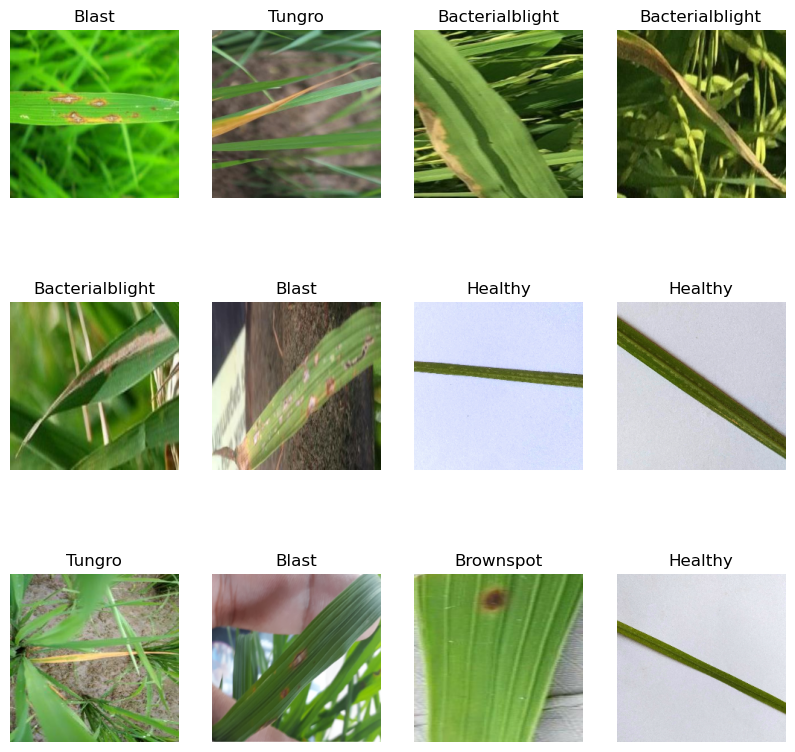

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12): #showing 12 images out of 32
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
# (32=batch_size, 256, 256=image_size, 0 to 3=typesofdiseases)
# 0 - Bacterial Blight
# 1 - Blast
# 2 - Brownspot
# 3 - Tungro

In [9]:
# Spitting dataset for training, validation and testing
# 80% for training 10% for validation and 10% for testing
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds =get_dataset_partitions_tf(dataset)

In [11]:
# Catching and prefeching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Preprocessing

In [12]:
# Layer for resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

## AlexNet

In [14]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes= 5

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(96,(11,11), strides=(4,4), activation='relu', input_shape = input_shape, padding='valid'),
    tf.keras.layers.BatchNormalization(),
    layers.MaxPooling2D((3,3),strides=(2,2)),

    layers.Conv2D(256,(5,5), strides=(1,1), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    layers.MaxPooling2D((3,3),strides=(2,2)),
    
    layers.Conv2D(384,(3,3), strides=(1,1), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    
    layers.Conv2D(384,(3,3), strides=(1,1), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    
    layers.Conv2D(256,(3,3), strides=(1,1), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    layers.MaxPooling2D((3,3),strides=(2,2)),
    
    layers.Flatten(),
    
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.4),
    tf.keras.layers.BatchNormalization(),
    
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.4),
    tf.keras.layers.BatchNormalization(),    
    
    layers.Dense(n_classes, activation='softmax'),
])

In [15]:
model.build(input_shape = input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 227, 227, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 227, 227, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)      

In [17]:
pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
     --------------------------------------- 47.0/47.0 kB 33.6 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install pydot

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [17]:
from keras.utils.vis_utils import plot_model

In [18]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [19]:
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics=['accuracy'])

In [20]:
logdir='logs'

In [21]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [22]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [23]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=[tensorboard_callback]
)

Epoch 1/30
148/148 [==============================] - 422s 3s/step - loss: 1.0913 - accuracy: 0.7293 - val_loss: 4.8537 - val_accuracy: 0.3663
Epoch 2/30
148/148 [==============================] - 379s 3s/step - loss: 0.5747 - accuracy: 0.8149 - val_loss: 5.6604 - val_accuracy: 0.3976
Epoch 3/30
148/148 [==============================] - 374s 3s/step - loss: 0.4857 - accuracy: 0.8410 - val_loss: 0.5962 - val_accuracy: 0.8351
Epoch 4/30
148/148 [==============================] - 380s 3s/step - loss: 0.4001 - accuracy: 0.8726 - val_loss: 4.0132 - val_accuracy: 0.5556
Epoch 5/30
148/148 [==============================] - 375s 3s/step - loss: 0.3737 - accuracy: 0.8925 - val_loss: 14.4192 - val_accuracy: 0.4097
Epoch 6/30
148/148 [==============================] - 359s 2s/step - loss: 0.3037 - accuracy: 0.9059 - val_loss: 1.2208 - val_accuracy: 0.7882
Epoch 7/30
148/148 [==============================] - 345s 2s/step - loss: 0.2747 - accuracy: 0.9150 - val_loss: 5.6260 - val_accuracy: 0.388

KeyboardInterrupt: 

In [ ]:
scores = model.evaluate(test_ds)
scores

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    prediction = model.predict(img_array)
    
    prediction_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])),2)
    
    return prediction_class, confidence

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f'predicted: {predicted_class},\n confidence: {confidence}, \n Actual: {actual_class}')
        plt.axis("off")

## Save and Load Model

In [ ]:
# Saving the model
model_version = max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f'models\{model_version}')

In [ ]:
new_model = tf.keras.models.load_model('models/6')

# Check its architecture
new_model.summary()

## Sample Predictions

In [ ]:
import numpy as np
import cv2

In [ ]:
img_path = cv2.imread(os.path.join('Testing Images','blast.jpg'))
plt.imshow(img_path)

In [ ]:
img1 = cv2.resize(img_path,(227,227))

In [ ]:
img1 = np.reshape(img1,[1,227,227,3])

In [ ]:
pred = new_model.predict(img1)

In [ ]:
prediction_class = class_names[np.argmax(pred)]

In [ ]:
prediction_class

In [ ]:
img2_path = cv2.imread(os.path.join('rice_leaf_disease_images', 'Brownspot','BROWNSPOT1_002.jpg'))
plt.imshow(img2_path)

In [ ]:
img2 = cv2.resize(img2_path,(227,227))
img2 = np.reshape(img2,[1,227,227,3])

In [ ]:
pred2 = new_model.predict(img2)

In [ ]:
pred2

In [ ]:
prediction_class = class_names[np.argmax(pred2)]
prediction_class

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = new_model.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = tf.concat([y for x, y in test_ds], axis=0)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(Y_true, Y_pred_classes, target_names=class_names))